In [171]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import linear_model
from math import sqrt
from datetime import datetime

from core.data.file_processing import open_all_data, inferred_land_sink, all_dgvms_gl
from core.data.data_processing import trend
from core.modeling import WindowGenerator, lstm_model, compile_and_fit, Baseline

# Import data 

In [2]:
df = open_all_data()
df_no_na = df.dropna()
df_no_na.index = pd.to_datetime(df_no_na.index).to_period("M")
df_iav = trend(df_no_na)

df_inf = inferred_land_sink()
df_inf = df_inf.dropna()
df_inf['Inferred_land_sink'] = df_inf['GL_ff_emissions'] \
                             + df_inf['LUC'] \
                             - df_inf['monthly_gr'] \
                             + df_inf['ocean_sink_GL'] # because already negative
df_inf['Inferred_land_sink'] = -1 * df_inf['Inferred_land_sink']
df_inf['Emission_flux'] = df_inf['GL_ff_emissions'] + df_inf['LUC']

df_inf_iav = trend(df_inf)

In [3]:
df_iav_select = df_iav[['land_sink_GL', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR', 'ENSO']]
df_inf_select = df_inf_iav[['Inferred_land_sink', 'Emission_flux']]

In [4]:
df_all = df_iav_select[1:].merge(df_inf_select, left_index=True, right_index=True)
df_all

,land_sink_GL,Landtemp_GL,Landtemp_TR,Pre_GL,Pre_TR,ENSO,Inferred_land_sink,Emission_flux
time,,,,,,,,
1980-02,0.092564,-0.283749,0.449947,67.260871,91.321893,0.5,-0.362497,0.555734
1980-03,0.086849,-0.241958,0.427786,67.368384,91.484640,0.3,-0.345074,0.554174
1980-04,0.081135,-0.200168,0.405626,67.475897,91.647387,0.4,-0.327651,0.552614
1980-05,0.075420,-0.158377,0.383465,67.583410,91.810135,0.5,-0.310229,0.551055
1980-06,0.069705,-0.116586,0.361305,67.690923,91.972882,0.5,-0.292806,0.549495
...,...,...,...,...,...,...,...,...
2019-08,-0.115516,1.163805,0.914567,69.557906,93.454402,0.1,-0.368421,0.972241
2019-09,-0.112590,1.176326,0.927641,69.428300,93.438218,0.2,-0.338518,0.974102
2019-10,-0.109141,1.189851,0.934879,69.458855,93.631625,0.3,-0.315865,0.975956


<AxesSubplot:xlabel='time'>

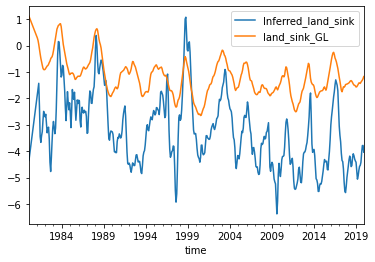

In [5]:
(12*df_all[['Inferred_land_sink', 'land_sink_GL']]).plot()

In [6]:
df_all[['land_sink_GL']]

,land_sink_GL
time,
1980-02,0.092564
1980-03,0.086849
1980-04,0.081135
1980-05,0.075420
1980-06,0.069705
...,...
2019-08,-0.115516
2019-09,-0.112590
2019-10,-0.109141


In [5]:
df_all['new'] = trend(all_dgvms_gl('core/data/').dropna()).mean(axis=1)

In [6]:
dgvms = trend(all_dgvms_gl('core/data/').dropna())

In [7]:
df_all = df_all.merge(dgvms, left_index=True, right_index=True)

In [8]:
# Inferred land sink uncertainty
unc = pd.read_csv('core/data/Inferred_land_sink_unc.csv', index_col=0)
unc = unc.set_index(pd.to_datetime(unc.index, format="%Y-%m")).to_period("M")

# Prepare data

In [9]:
df = df_all.copy()
df.columns

Index(['land_sink_GL', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR',
       'ENSO', 'Inferred_land_sink', 'Emission_flux', 'new', 'CLM5.0', 'IBIS',
       'ISAM', 'ISBA-CTRIP', 'JSBACH', 'JULES-ES', 'LPJ', 'LPX-Bern', 'OCN',
       'ORCHIDEEv3', 'SDGVM', 'VISIT', 'YIBs'],
      dtype='object')

(array([ 24.,  28., 114.,  90., 106.,  56.,  22.,  13.,  16.,  10.]),
 array([-0.22082692, -0.18948782, -0.15814872, -0.12680962, -0.09547051,
        -0.06413141, -0.03279231, -0.00145321,  0.0298859 ,  0.061225  ,
         0.0925641 ]),
 <BarContainer object of 10 artists>)

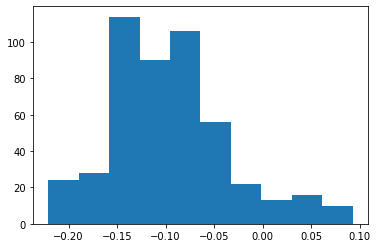

In [10]:
plt.hist(df[['land_sink_GL']])

In [11]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [47]:
test_df_pure = df[int(n*0.9):]

In [12]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [16]:
test_df.index

PeriodIndex(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
             '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
             '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
             '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12',
             '2018-01', '2018-02', '2018-03', '2018-04', '2018-05', '2018-06',
             '2018-07', '2018-08', '2018-09', '2018-10', '2018-11', '2018-12',
             '2019-01', '2019-02', '2019-03', '2019-04', '2019-05', '2019-06',
             '2019-07', '2019-08', '2019-09', '2019-10', '2019-11', '2019-12'],
            dtype='period[M]', name='time', freq='M')

## Correlations

In [96]:
import seaborn as sb

In [90]:
df.columns

Index(['land_sink_GL', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR',
       'ENSO', 'Inferred_land_sink', 'Emission_flux'],
      dtype='object')

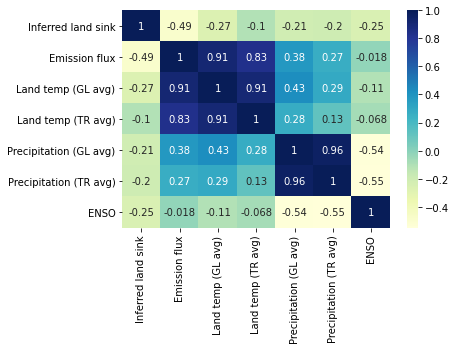

In [137]:
df_corr = df[['Inferred_land_sink', 'Emission_flux', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR', 'ENSO']]
#df_corr.plot()
df_corr = df_corr.rename(columns={'Inferred_land_sink': 'Inferred land sink', 'Emission_flux': 'Emission flux', 'Landtemp_GL': 'Land temp (GL avg)', 'Landtemp_TR': 'Land temp (TR avg)', 'Pre_GL': 'Precipitation (GL avg)', 'Pre_TR': 'Precipitation (TR avg)' })

#plt.figure(figsize=(8, 6), dpi=16)
dataplot = sb.heatmap(df_corr.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [57]:
def linear_model():
    linear = tf.keras.Sequential([
        tf.keras.layers.Dense(units=1)
    ])
    return linear

### RUN TRIALS

In [219]:
df_all.columns

Index(['land_sink_GL', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR',
       'ENSO', 'Inferred_land_sink', 'Emission_flux', 'new', 'CLM5.0', 'IBIS',
       'ISAM', 'ISBA-CTRIP', 'JSBACH', 'JULES-ES', 'LPJ', 'LPX-Bern', 'OCN',
       'ORCHIDEEv3', 'SDGVM', 'VISIT', 'YIBs'],
      dtype='object')

In [69]:
MAX_EPOCHS = 50
dependent_variable = 'Inferred_land_sink'

# Track the best overall model
best_model = None
best_MAE = 1000000000
best_model_name = ""

# Set up DF to store training/testing info across all tests
columns = ['Val loss', 'Val MAE', 'Test loss', 'Test MAE', 'Best Epoch',
           'Num_Batches', 'Batch_Size_data', 'Timestep',
           'Batch_size_train', 'Dependent', 'Variables', 'Name', 'Model Number', 'Time']
eval_df = pd.DataFrame(columns=columns)
predictions_df = pd.DataFrame(index=test_df.index[1:])

In [70]:
independent_variable_sets = [
    #['Emission_flux', 'Landtemp_TR', 'Landtemp_GL', 'Pre_GL', 'Pre_TR', 'ENSO']
    [],
]

In [71]:
experiment_number = 0

dependent_variable = "Inferred_land_sink"


for independent_variables in independent_variable_sets:

    # Select data
    variables = [dependent_variable] + independent_variables
    train_df_use = train_df[variables]
    val_df_use = val_df[variables]
    test_df_use = test_df[variables]

    TIMESTEP_LENGTH = 6
    DATA_BATCH_SIZE = 10

    experiment_number = experiment_number + 1

    # Create window for training (data partition)
    wide_window = WindowGenerator(
            input_width=TIMESTEP_LENGTH, label_width=TIMESTEP_LENGTH, shift=1,
            train_df=train_df_use, val_df=val_df_use, test_df=test_df_use,
            sequence_stride=1, batch_size=DATA_BATCH_SIZE,
            label_columns=[dependent_variable])

    # Set up window for taking all predictions
    test_window = WindowGenerator(
            input_width=len(test_df_use)-1, label_width=len(test_df_use)-1, shift=1,
            train_df=train_df_use, val_df=val_df_use, test_df=test_df_use,
            sequence_stride=1, batch_size=20,
            label_columns=[dependent_variable])
    inputs, labels = next(iter(test_window.test))
    label_col_index = test_window.label_columns_indices.get(dependent_variable, None)

    for i in range(10):

        start=datetime.now()
        model_name = f'model_{experiment_number}_run_{i}'
        print(f"Running Model {model_name}")
        curr_lstm = linear_model()

        history = compile_and_fit(curr_lstm, wide_window, max_epochs=MAX_EPOCHS)

        stopped_epoch = history.history['val_loss'].index(min(history.history['val_loss']))
        val_performance = curr_lstm.evaluate(wide_window.val, verbose=0)
        performance = curr_lstm.evaluate(wide_window.test, verbose=0)

        df_vals = {'Val loss': val_performance[0],
                   'Val MAE': val_performance[1],
                   'Test loss': performance[0],
                   'Test MAE': performance[1],
                   'Best Epoch': stopped_epoch,
                   'Num_Batches': len(wide_window.train),
                   'Batch_Size_data': wide_window.batch_size,
                   'Timestep': wide_window.input_width,
                   'Batch_size_train': 'NA',
                   'Dependent': dependent_variable,
                   'Variables': independent_variables,
                   'Name': model_name,
                   'Model Number': experiment_number,
                   'Time': (datetime.now()-start)}

        eval_df = eval_df.append(df_vals, ignore_index=True)

        predictions = curr_lstm(inputs)
        predictions_df[model_name] = curr_lstm(inputs)[0, :, label_col_index]

        if performance[1] < best_MAE:
            best_MAE = performance[1]
            best_model = curr_lstm
            best_model_name = model_name

Running Model model_1_run_0
Running Model model_1_run_1
Running Model model_1_run_2
Running Model model_1_run_3
Running Model model_1_run_4
Running Model model_1_run_5
Running Model model_1_run_6
Running Model model_1_run_7
Running Model model_1_run_8
Running Model model_1_run_9


In [59]:
eval_df.groupby('Model Number').mean()

,Val loss,Val MAE,Test loss,Test MAE
Model Number,,,,
1,0.343715,0.415699,0.340225,0.366273


In [66]:
eval_df.groupby('Model Number').mean()

,Val loss,Val MAE,Test loss,Test MAE
Model Number,,,,
1,0.084927,0.232867,0.059006,0.192421


In [72]:
eval_df.groupby('Model Number').mean()

,Val loss,Val MAE,Test loss,Test MAE
Model Number,,,,
1,0.520866,0.442671,0.42916,0.411333


In [68]:
RUN_NAME = "LSTM_multi"

predictions_df.to_csv(f'RUNS/predictions_{RUN_NAME}.csv')
eval_df.to_csv(f'RUNS/eval_{RUN_NAME}.csv')
eval_df.groupby('Model Number').std().to_csv(f'RUNS/eval_std_{RUN_NAME}.csv')
eval_df.groupby('Model Number').mean().to_csv(f'RUNS/eval_mean_{RUN_NAME}.csv')

### Plot results

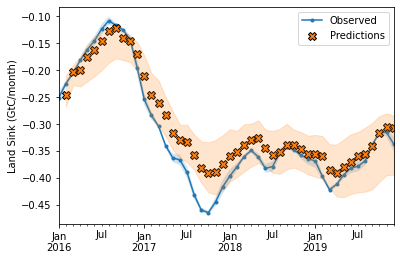

In [67]:
errors = unc.join(test_df[dependent_variable], how='right')

# Choose if I'm plotting train, val, or test:
to_plot = test_df

# Get the predictions of just the chosen model:
predictions_df_use = predictions_df[[col for col in predictions_df if col.startswith('model_1')]]
#predictions_df_use = predictions_df

# Unnormalize the datasets:
to_plot_gtc = to_plot * train_std + train_mean
predictions_df_gtc = predictions_df_use * train_std[dependent_variable] + train_mean[dependent_variable]

# Plot the actual values:
to_plot_gtc[dependent_variable].plot(label='Observed', marker='.', zorder=-10, xlabel="", ylabel="Land Sink (GtC/month)")

# Plot errors for actual:
errors = unc.join(to_plot_gtc[dependent_variable], how='right')
lower_error_inf = errors[dependent_variable] - errors['unc']
upper_error_inf = errors[dependent_variable] + errors['unc']
plt.fill_between(to_plot_gtc[dependent_variable].index, lower_error_inf, upper_error_inf, alpha=0.2)

# Plot the predicted values of the best model:
plt.scatter(to_plot_gtc.index[1:], predictions_df_gtc[best_model_name],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64)

# Plot min to max as error bars for the models:
lower_error = predictions_df_gtc.min(axis=1).values
upper_error = predictions_df_gtc.max(axis=1).values
plt.fill_between(to_plot_gtc.index[1:], lower_error, upper_error, alpha=0.2, color='#ff7f0e')

plt.legend()

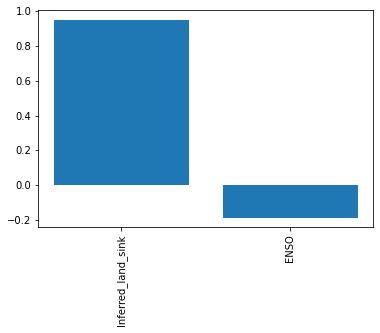

In [26]:
plt.bar(x = range(len(train_df_use.columns)),
        height=best_model.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df_use.columns)))
_ = axis.set_xticklabels(train_df_use.columns, rotation=90)

### See importance of each variable

In [454]:
class WindowGenerator():
    def __init__(self,
                 input_width,  # num of inputs each; i.e. timestep
                 label_width,  # num to predict
                 shift, # deplay between input & label,
                 train_df, val_df, test_df,
                 sequence_stride=1,
                 batch_size=10,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                          enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.sequence_stride = sequence_stride
        self.batch_size = batch_size

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join([
            f'Total window size: {self.total_window_size}',
            f'Input indices: {self.input_indices}',
            f'Label indices: {self.label_indices}',
            f'Label column name(s): {self.label_columns}'])

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
              [labels[:, :, self.column_indices[name]] for name in self.label_columns],
              axis=-1)
            input_names = [ name for name in self.test_df.columns if name not in wide_window.label_columns]
            #other = tf.stack(
            #  [inputs[:, :, self.column_indices[name]] for name in input_names],
            #  axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])
        #other.set_shape([None, self.input_width, None])

        return inputs, labels

        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=self.sequence_stride, # Period between successive output sequences. 
            shuffle=True,
            batch_size=self.batch_size,)

        ds = ds.map(self.split_window)

        return ds
    
    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

In [34]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

In [74]:
wide_window = WindowGenerator(
    input_width=len(test_df_use)-1, label_width=len(test_df_use)-1, shift=1,
    train_df=train_df, val_df=val_df, test_df=test_df,
    label_columns=['Inferred_land_sink'])


In [75]:
baseline = Baseline(label_index=column_indices['Inferred_land_sink'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test)

1/1 [==============================] - 0s 60ms/step - loss: 0.0468 - mean_absolute_error: 0.1829


In [ ]:
class ResidualWrapper(tf.keras.Model):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)

        # The prediction for each timestep is the input
        # from the previous time step plus the delta
        # calculated by the model.
        return inputs + delta

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    train_df=train_df_use, val_df=val_df_use, test_df=test_df_use,
    label_columns=[dependent_variable])

wide_window = WindowGenerator(
        input_width=24, label_width=24, shift=1,
        train_df=train_df_use, val_df=val_df_use, test_df=test_df_use,
        sequence_stride=1, batch_size=10,
        label_columns=[dependent_variable])

print("There are {} batches".format(len(wide_window.train)))
print("There are {} samples per batch".format(next(iter(wide_window.train))[0].shape[0]))
print("There are {} timesteps per sample".format(next(iter(wide_window.train))[0].shape[1]))

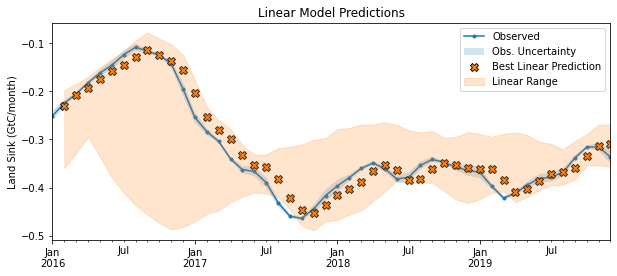

In [301]:
plt.figure(figsize=(10,4))

sheet = pd.read_csv('RUNS/predictions_LINEAR_multi.csv', index_col=0)
model_name_to_plot = "model_1_run_1"
errors = unc.join(test_df[dependent_variable], how='right')

# Choose if I'm plotting train, val, or test:
to_plot_gtc = test_df_pure

# Plot the actual values:
to_plot_gtc[dependent_variable].plot(label='Observed', marker='.', zorder=-10, xlabel="", ylabel="Land Sink (GtC/month)")

# Plot errors for actual:
errors = unc.join(to_plot_gtc[dependent_variable], how='right')
lower_error_inf = errors[dependent_variable] - errors['unc']
upper_error_inf = errors[dependent_variable] + errors['unc']
plt.fill_between(to_plot_gtc[dependent_variable].index, lower_error_inf, upper_error_inf, alpha=0.2, label="Obs. Uncertainty")


# Get the predictions of just the chosen model:
predictions_df_use = sheet[[col for col in sheet if col.startswith('model_1')]]
#predictions_df_use = predictions_df

# Un-normalize
predictions_df_gtc = predictions_df_use * train_std[dependent_variable] + train_mean[dependent_variable]

# Plot the predicted values of the best model:
plt.scatter(to_plot_gtc.index[1:], predictions_df_gtc[model_name_to_plot],
            marker='X', edgecolors='k', label='Best Linear Prediction',
            c='#ff7f0e', s=64)

# Plot min to max as error bars for the models:
lower_error = predictions_df_gtc.min(axis=1).values
upper_error = predictions_df_gtc.max(axis=1).values
plt.fill_between(to_plot_gtc.index[1:], lower_error, upper_error, alpha=0.2, color='#ff7f0e', label="Linear Range")

plt.title("Linear Model Predictions")

plt.legend()

In [189]:
actual = test_df_pure[dependent_variable][1:]
for i in range(9):
    model_name_to_plot = 'model_1_run_{}'.format(i)
    predicted = sheet[model_name_to_plot] * train_std[dependent_variable] + train_mean[dependent_variable]
    error = mean_absolute_error(actual, predicted)
    print(error)

0.028557354343680598
0.03303844714091488
0.020889345079493207
0.026989522609689568
0.019562481342319603
0.05419753847343369
0.0340914521099619
0.030486338170698395
0.03165206773138824


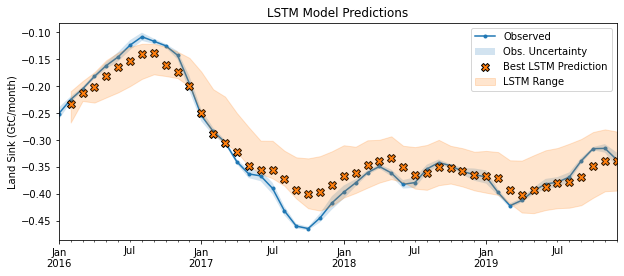

In [188]:
plt.figure(figsize=(10,4))

sheet = pd.read_csv('RUNS/predictions_LSTM_multi.csv', index_col=0)
model_name_to_plot = "model_1_run_4"
errors = unc.join(test_df[dependent_variable], how='right')

# Choose if I'm plotting train, val, or test:
to_plot_gtc = test_df_pure

# Plot the actual values:
to_plot_gtc[dependent_variable].plot(label='Observed', marker='.', zorder=-10, xlabel="", ylabel="Land Sink (GtC/month)")

# Plot errors for actual:
errors = unc.join(to_plot_gtc[dependent_variable], how='right')
lower_error_inf = errors[dependent_variable] - errors['unc']
upper_error_inf = errors[dependent_variable] + errors['unc']
plt.fill_between(to_plot_gtc[dependent_variable].index, lower_error_inf, upper_error_inf, alpha=0.2, label="Obs. Uncertainty")


# Get the predictions of just the chosen model:
predictions_df_use = sheet[[col for col in sheet if col.startswith('model_1')]]
#predictions_df_use = predictions_df

# Un-normalize
predictions_df_gtc = predictions_df_use * train_std[dependent_variable] + train_mean[dependent_variable]

# Plot the predicted values of the best model:
plt.scatter(to_plot_gtc.index[1:], predictions_df_gtc[model_name_to_plot],
            marker='X', edgecolors='k', label='Best LSTM Prediction',
            c='#ff7f0e', s=64)

# Plot min to max as error bars for the models:
lower_error = predictions_df_gtc.min(axis=1).values
upper_error = predictions_df_gtc.max(axis=1).values
plt.fill_between(to_plot_gtc.index[1:], lower_error, upper_error, alpha=0.2, color='#ff7f0e', label="LSTM Range")

plt.title("LSTM Model Predictions")

plt.legend()
plt.show()

## Baseline Plot

AttributeError: 'Figure' object has no attribute 'plot'

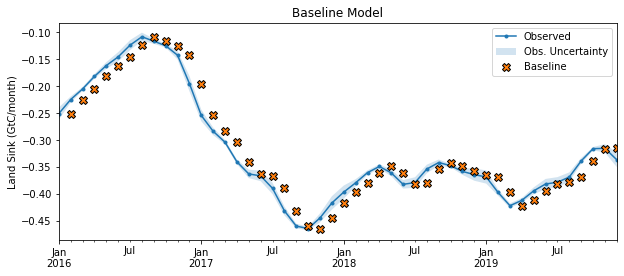

In [191]:
plt.figure(figsize=(10,4))

errors = unc.join(test_df[dependent_variable], how='right')

# Choose if I'm plotting train, val, or test:
to_plot = test_df_pure

base = baseline.predict(wide_window.test)[0] * train_std['Inferred_land_sink'] + train_mean['Inferred_land_sink']


to_plot[dependent_variable].plot(label='Observed', marker='.', zorder=-10, xlabel="", ylabel="Land Sink (GtC/month)")


errors = unc.join(to_plot_gtc[dependent_variable], how='right')
lower_error_inf = errors[dependent_variable] - errors['unc']
upper_error_inf = errors[dependent_variable] + errors['unc']
plt.fill_between(to_plot_gtc[dependent_variable].index, lower_error_inf, upper_error_inf, alpha=0.2, label='Obs. Uncertainty')

plt.scatter(to_plot_gtc.index[1:], base,
            marker='X', edgecolors='k', label='Baseline',
            c='#ff7f0e', s=64)

plt.title("Baseline Model")
plt.legend()
plt.show()

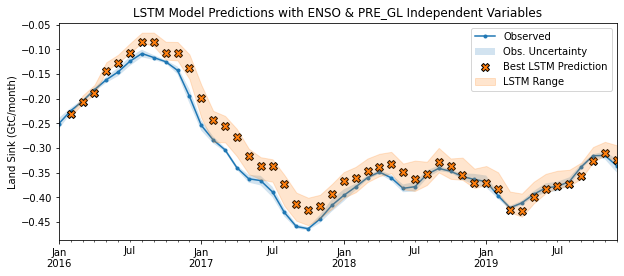

In [198]:
plt.figure(figsize=(10,4))

sheet = pd.read_csv('RUNS/predictions_Multi_2.csv', index_col=0)
model_name_to_plot = "model_14_run_4"
errors = unc.join(test_df[dependent_variable], how='right')

# Choose if I'm plotting train, val, or test:
to_plot_gtc = test_df_pure

# Plot the actual values:
to_plot_gtc[dependent_variable].plot(label='Observed', marker='.', zorder=-10, xlabel="", ylabel="Land Sink (GtC/month)")

# Plot errors for actual:
errors = unc.join(to_plot_gtc[dependent_variable], how='right')
lower_error_inf = errors[dependent_variable] - errors['unc']
upper_error_inf = errors[dependent_variable] + errors['unc']
plt.fill_between(to_plot_gtc[dependent_variable].index, lower_error_inf, upper_error_inf, alpha=0.2, label="Obs. Uncertainty")


# Get the predictions of just the chosen model:
predictions_df_use = sheet[[col for col in sheet if col.startswith('model_14')]]
#predictions_df_use = predictions_df

# Un-normalize
predictions_df_gtc = predictions_df_use * train_std[dependent_variable] + train_mean[dependent_variable]

# Plot the predicted values of the best model:
plt.scatter(to_plot_gtc.index[1:], predictions_df_gtc[model_name_to_plot],
            marker='X', edgecolors='k', label='Best LSTM Prediction',
            c='#ff7f0e', s=64)

# Plot min to max as error bars for the models:
lower_error = predictions_df_gtc.min(axis=1).values
upper_error = predictions_df_gtc.max(axis=1).values
plt.fill_between(to_plot_gtc.index[1:], lower_error, upper_error, alpha=0.2, color='#ff7f0e', label="LSTM Range")

plt.title("LSTM Model Predictions with ENSO & PRE_GL Independent Variables")

plt.legend()
plt.show()

In [270]:
sheetysheet = pd.read_csv('RUNS/predictions_testing_timestep.csv', index_col=0)

model_2_run_9
model_6_run_1
model_10_run_8
model_14_run_7
model_18_run_9
model_22_run_4
model_26_run_5


model_2_run_9
model_6_run_1
model_10_run_8
model_14_run_7
model_18_run_9
model_22_run_4
model_26_run_5


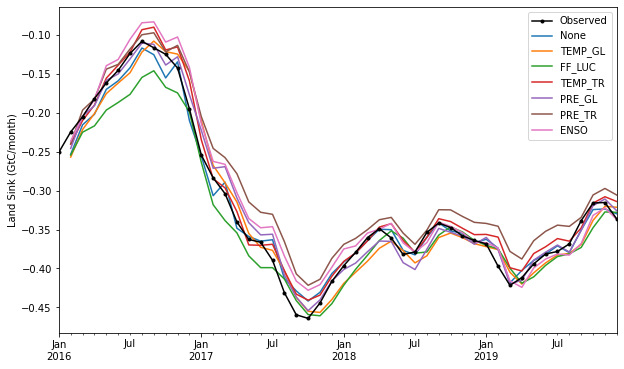

In [299]:
plt.figure(figsize=(10,6))
# Choose if I'm plotting train, val, or test:
to_plot_gtc = test_df_pure

# Plot the actual values:
to_plot_gtc[dependent_variable].plot(label='Observed', marker='.', zorder=10, xlabel="", ylabel="Land Sink (GtC/month)", c='black')




actual = test_df[dependent_variable][1:]
sheetysheet_gtc = sheetysheet * train_std[dependent_variable] + train_mean[dependent_variable]

names = {2: 'None', 6: 'TEMP_GL', 10: 'FF_LUC', 14: 'TEMP_TR', 18: 'PRE_GL', 22: 'PRE_TR', 26: 'ENSO'}

for i in [2, 6, 10, 14, 18, 22, 26]:
    best_error = 10
    best = model_name_to_plot
    for j in range(10):
        model_name_to_plot = 'model_{}_run_{}'.format(i, j)
        predicted = sheetysheet[model_name_to_plot]
        error = mean_absolute_error(actual, predicted)
        if error < best_error:
            best_error = error
            best = model_name_to_plot
    
    # Plot the predicted values of the best model:
    plt.plot(to_plot_gtc.index[1:], sheetysheet_gtc[model_name_to_plot],
            label=names[i])

    print(best)

# Plot the actual values:


    
plt.legend()

In [300]:
df_all.columns

Index(['land_sink_GL', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR',
       'ENSO', 'Inferred_land_sink', 'Emission_flux', 'new', 'CLM5.0', 'IBIS',
       'ISAM', 'ISBA-CTRIP', 'JSBACH', 'JULES-ES', 'LPJ', 'LPX-Bern', 'OCN',
       'ORCHIDEEv3', 'SDGVM', 'VISIT', 'YIBs'],
      dtype='object')

In [210]:
df_all_corr = df_all[['Inferred_land_sink', 'Landtemp_GL', 'Landtemp_TR', 'Pre_GL', 'Pre_TR', 'ENSO', 'Emission_flux']]

In [222]:
df_all_corr = df_all_corr.rename(columns={"Landtemp_GL": "TEMP_GL", "Landtemp_TR": "TEMP_TR", 'Pre_GL': 'PRE_GL', 'Pre_TR': 'PRE_TR', 'Inferred_land_sink': 'ILS', 'Emission_flux': 'FF_LUC'})

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0, 0.5, 'ILS'),
  Text(0, 1.5, 'TEMP_GL'),
  Text(0, 2.5, 'TEMP_TR'),
  Text(0, 3.5, 'PRE_GL'),
  Text(0, 4.5, 'PRE_TR'),
  Text(0, 5.5, 'ENSO'),
  Text(0, 6.5, 'FF_LUC')])

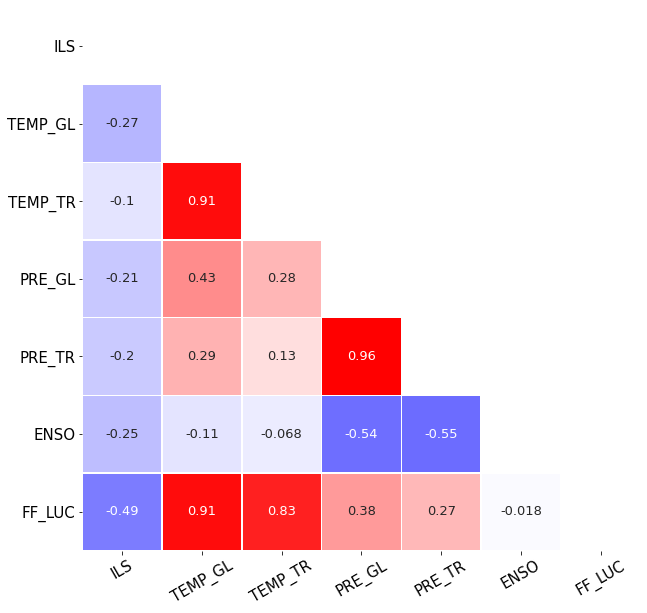

In [266]:
import seaborn as sns
corr = df_all_corr.corr()

mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr[mask] = np.nan

plt.figure(figsize=(10,10))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
           annot=True, cbar=False, cmap="bwr", linewidths=.5, center=0, annot_kws={"size": 13})

plt.xticks(rotation=30, size=15)
plt.yticks(rotation=0, size=15)

In [254]:
sns.reset_orig()

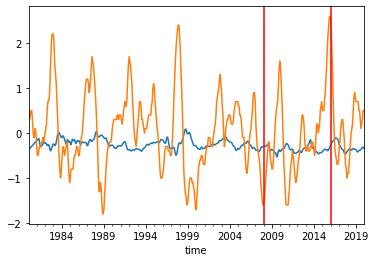

In [307]:
df_all['Inferred_land_sink'].plot()
df_all['ENSO'].plot()
plt.axvline(x='01/2016', c='red')
plt.axvline(x='01/2008', c='red')